In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# import Keras Network lib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, GRU

# import RMSE,MSE,MAPE lib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score

In [2]:
# 2. Đọc file csv và gắng index với giá Close
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/PTDLKD/BTC-USD.csv',index_col=0,parse_dates=True)



df1=df[['Close']]
df1.head(10)

Mounted at /content/gdrive


,Close
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000
2018-01-06,17527.000000
2018-01-07,16477.599609
2018-01-08,15170.099609
2018-01-09,14595.400391


In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+49 and Y=t+40

time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 3s 52ms/step - loss: 0.0341 - val_loss: 0.0049
Epoch 2/100
20/20 [==============================] - 1s 39ms/step - loss: 0.0023 - val_loss: 0.0060
Epoch 3/100
20/20 [==============================] - 1s 28ms/step - loss: 7.7385e-04 - val_loss: 0.0012
Epoch 4/100
20/20 [==============================] - 1s 28ms/step - loss: 4.7238e-04 - val_loss: 0.0010
Epoch 5/100
20/20 [==============================] - 1s 26ms/step - loss: 4.1360e-04 - val_loss: 0.0011
Epoch 6/100
20/20 [==============================] - 1s 27ms/step - loss: 4.2018e-04 - val_loss: 9.5661e-04
Epoch 7/100
20/20 [==============================] - 1s 27ms/step - loss: 3.9274e-04 - val_loss: 0.0010
Epoch 8/100
20/20 [==============================] - 1s 27ms/step - loss: 3.7079e-04 - val_loss: 0.0010
Epoch 9/100
20/20 [==============================] - 1s 27ms/step - loss: 3.3544e-04 - val_loss: 8.4302e-04
Epoch 10/100
20/20 [==============================] - 1s 28ms/st

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

13/13 [==============================] - 0s 6ms/step


In [11]:
rmse = mean_squared_error(ytest, y_pred, squared=False)
print("RMSE on test set: {:.3f}".format(rmse))
rmse = mean_squared_error(yval, y_pred_val, squared=False)
print("RMSE on validation set: {:.3f}".format(rmse))
mape = mean_absolute_percentage_error(ytest, y_pred)
print("MAPE on test set: {:.3f}".format(mape))
mape = mean_absolute_percentage_error(yval, y_pred_val)
print("MAPE on validation set: {:.3f}".format(mape))
evs = explained_variance_score(ytest, y_pred)
print("The explained variance score (EVS) on test set: {:.3f}".format(evs))
evs = explained_variance_score(yval, y_pred_val)
print("The explained variance score (EVS) on validate set: {:.3f}".format(evs))

RMSE on test set: 0.024
RMSE on validation set: 0.011
MAPE on test set: 0.032
MAPE on validation set: 0.025
The explained variance score (EVS) on test set: 0.986
The explained variance score (EVS) on validate set: 0.983


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()



lst_output = []
n_steps = 100
i = 0
while i < 30 and len(temp_input) >= n_steps:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.40401993 0.40600317 0.40376031 0.40544781 0.40603341 0.40476481
 0.40406222 0.41098933 0.40284736 0.40326273 0.40163693 0.40114004
 0.40113582 0.40329224 0.41238463 0.40921351 0.40716311 0.40666759
 0.40695128 0.40488303 0.40683436 0.40313321 0.39584939 0.36418102
 0.35462104 0.35534618 0.35679774 0.35578043 0.35434278 0.36056047
 0.35637475 0.35459168 0.35398224 0.35524496 0.35550078 0.38070271
 0.37401646 0.35278544 0.35075299 0.35181119 0.3533776  0.35093473
 0.35043055 0.35001479 0.35758448 0.3523841  0.35222902 0.35124268
 0.34083429 0.35126005 0.35739995 0.36223983 0.36331272 0.36268452
 0.36215454 0.36557586 0.3726773  0.37144756 0.36267444 0.36285998
 0.36285722 0.35784301 0.35849052 0.3572278  0.35933361 0.36973046
 0.36802323 0.36889678 0.38468775 0.37764648 0.37607946 0.38182197
 0.3758608  0.38411022 0.38445597 0.38393133 0.37846869 0.37547385
 0.3674263  0.365615   0.36725616 0.36724578 0.37187729 0.39301537
 0.39140308 0.39004437 0.39612962 0.41110151 0.414

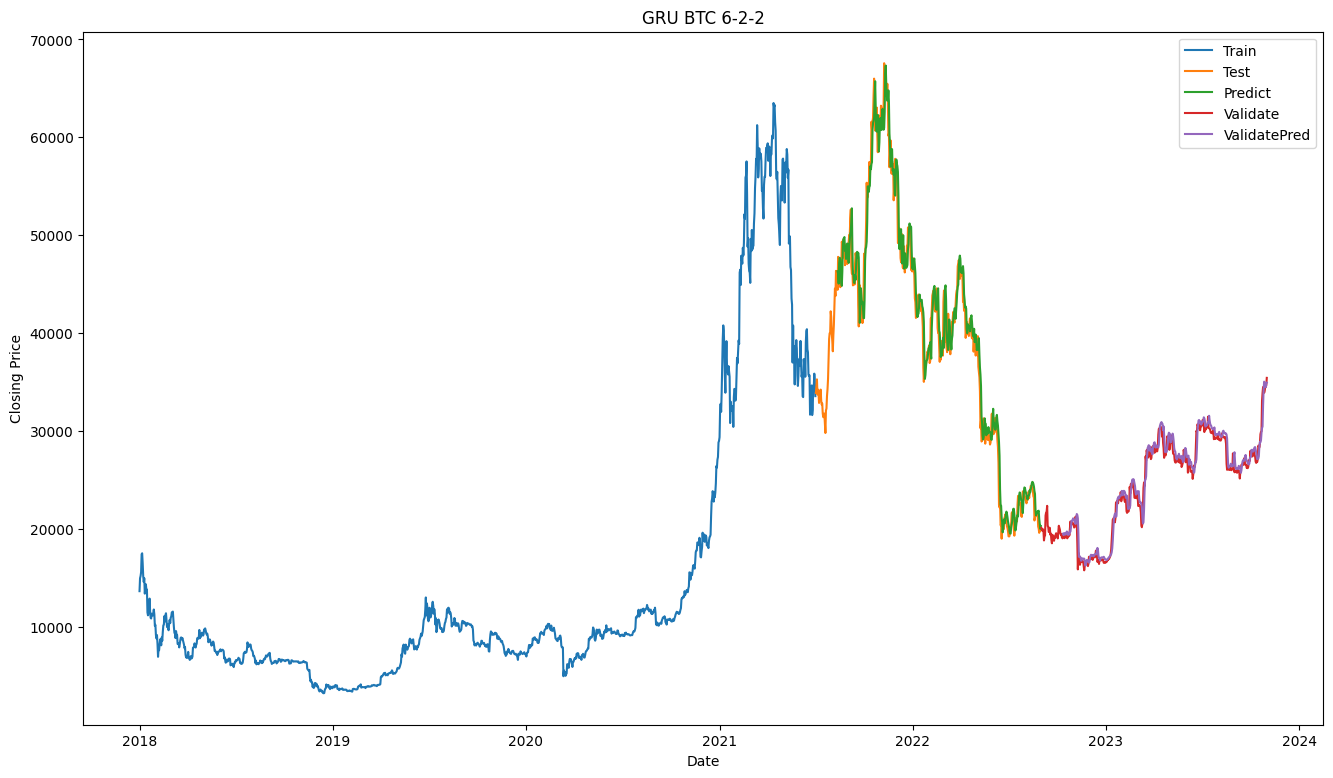

In [16]:
# 16.Vẽ hình
plt.figure(figsize=(16,9))
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('GRU BTC 6-2-2')
train_index = df[:train_size].index
plt.plot(train_index,scaler.inverse_transform(train_data))
#test
test_index = df[train_size:train_size+test_size].index
plt.plot(test_index,scaler.inverse_transform(test_data))
#test predict
test_predict_index = df[train_size+41:train_size+test_size].index
plt.plot(test_predict_index,(y_pred))
#val
val_index = df[train_size+test_size:train_size+test_size+val_size].index
plt.plot(val_index,scaler.inverse_transform(val_data))
#val predict
val_predict_index = df[train_size+test_size+41:train_size+test_size+val_size].index
plt.plot(val_predict_index,y_pred_val)
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

